Portfolio Management Project
- Method to build optimal portfolio combination using T-bill treasury and some large companies' stocks (A snapshot in time)
    a. approximate the risk&return relationship based on linear combination of different stocks 
    b. find tangent line of the previous curve and T-bill point
    c. find the optimal point
- Result Verification
    a. return over 6 month based on portfolio management vs uniform selection vs stock with highest expected return
    b. adjust the portfolio -- see change within 6 month on mean, variance, and covariance of the stocks
    c. compare again


In [551]:
#Packages Imported
import numpy as np
import pandas as pd
from yahoofinancials import YahooFinancials
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plot
import scipy.optimize as spyop



In [552]:
#Load Data

TSLA = yf.download("TSLA", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Google
AAPL = yf.download("AAPL", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Apple
JPM = yf.download("JPM", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Facebook
AMZN = yf.download("AMZN", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Amazon
COST = yf.download("COST", start="2012-05-20", end="2024-06-10",group_by="ticker") # Stock of Microsoft
STK_list = [TSLA, AAPL, JPM, AMZN, COST]
print(TSLA.shape, AAPL.shape, JPM.shape, AMZN.shape,COST.shape,)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(3032, 6) (3032, 6) (3032, 6) (3032, 6) (3032, 6)


In [553]:
STK_df = pd.concat([company['Close'] for company in STK_list], axis=1)
STK_df.columns = ['TSLA', 'AAPL', 'JPM', 'AMZN', 'COST']
STK_df.head()
STK_df.index

DatetimeIndex(['2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-29', '2012-05-30', '2012-05-31',
               '2012-06-01', '2012-06-04',
               ...
               '2024-05-24', '2024-05-28', '2024-05-29', '2024-05-30',
               '2024-05-31', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07'],
              dtype='datetime64[ns]', name='Date', length=3032, freq=None)

To estimate the monthly mean return and monthly risk (fluctuations) of the stock, the first 10 yrs of stock prices will be used, and then the effectiveness of tangency portfolio will be verified through the testing data in the remaining 2 yrs. 

<Axes: xlabel='Date'>

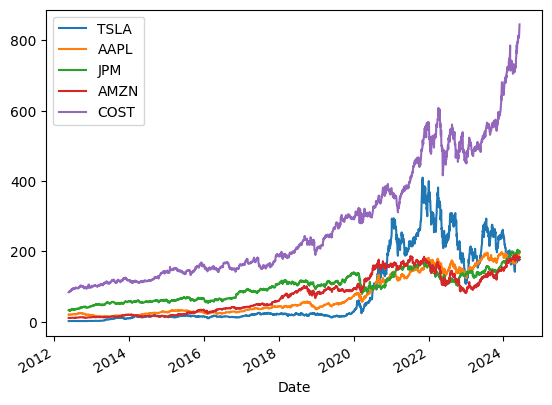

In [554]:
STK_df.plot()

Given the years before 2016 perform quite different from the following yrs, we will only use data after 2016, specifically from 2016 to 2022 to construct our tangency portfolio

In [555]:
STK_df_raw = np.log(STK_df/STK_df.shift(1)).dropna()
STK_df_return = STK_df_raw[((STK_df_raw.index >= '2016-06-01') & (STK_df_raw.index < '2023-06-01')) ]


$$
    Mean (R \_ mu) = E[R_i] = \mu_i\\
    Standard Deciation (R \_ std) = \sqrt{E[(R_i - \mu_i)^2]} = \sigma_i\\
    Cov[R_i, R_j] = E[(R_i-\mu_i)(R_j-\mu_j)] = \sigma_i \sigma_j \rho._{ij} \\
    Corr_{ij} = \frac{Cov[R_i, R_j]}{\sigma_i \sigma_j}
$$

Standard Deviation of the portfolio with weights:
$$
    Standard Deviation(R_p) = \sqrt{\sum_{i=1}^n \omega_i^2 \sigma_i^2 + \sum_{i\neq j} \omega_i \omega_j \sigma_i \sigma_j \rho._{ij}}
    
$$

Text(0.5, 1.0, 'Bar Chart for Average Return')

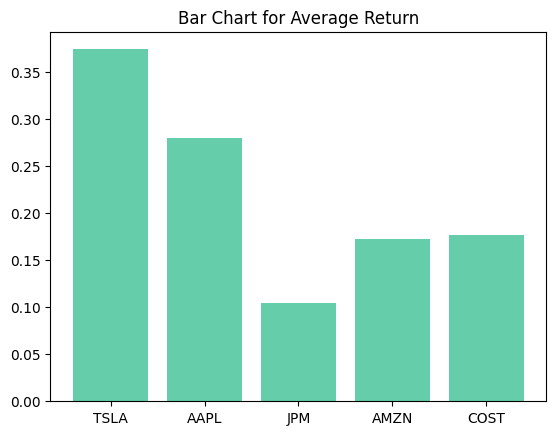

In [556]:
#calculate mean, standard deviation and covariance
R_mu = STK_df_return.mean() * 252
plot.bar(R_mu.index, R_mu, color = 'mediumaquamarine')
plot.title("Bar Chart for Average Return")

Text(0.5, 1.0, 'Bar Chart for Magnitude of Risk')

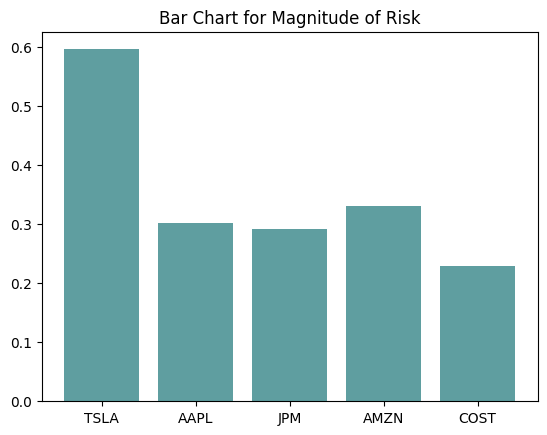

In [557]:
R_std = STK_df_return.std() * np.sqrt(252)
plot.bar(R_std.index, R_std, color = 'cadetblue')
plot.title("Bar Chart for Magnitude of Risk")

In [558]:
R_corr = STK_df_return.corr()
R_corr.style.background_gradient(cmap='GnBu')


,TSLA,AAPL,JPM,AMZN,COST
TSLA,1.000000,0.458474,0.267061,0.416746,0.288892
AAPL,0.458474,1.000000,0.445725,0.628734,0.513189
JPM,0.267061,0.445725,1.000000,0.301937,0.322676
AMZN,0.416746,0.628734,0.301937,1.000000,0.462207
COST,0.288892,0.513189,0.322676,0.462207,1.000000


In [559]:
def Std_Portfolio(weights, std_ls, corr_mx):
    var_port = 0
    for i in range(len(std_ls)):
        var_port = var_port + weights[i]**2 * std_ls.iloc[i]**2
        for j in range(i+1, len(std_ls)):
            var_port = var_port+ 2*weights[i]*weights[j]*std_ls.iloc[i]*std_ls.iloc[j]*corr_mx.iloc[i,j]
    std_port = np.sqrt(var_port)
    return std_port
    

In [560]:
# Assume 1 yr treasury bill rate is 5%
TRSRY = 0.05

In [561]:
# sample 10,000 combination of stocks and plot them
def Stat_Portfolio(weights, mu_ls, std_ls, corr_mx, T_rate ):
    pm = sum([weights[l] * R_mu.iloc[l] for l in range(len(mu_ls))])
    pstd = Std_Portfolio(weights,std_ls,corr_mx)
    psharpe = (pm-T_rate)/pstd
    return [pm, pstd, psharpe]

iter = 10000
pm = []
pstd = []
psharpe = []

for k in range(iter):   
    weights_p = np.random.dirichlet(np.ones(len(STK_df_return.columns)),size = 1)[0]
    port_stat = Stat_Portfolio(weights_p, R_mu, R_std, R_corr, TRSRY)
    pm.append(port_stat[0])
    pstd.append(port_stat[1])
    psharpe.append(port_stat[2])




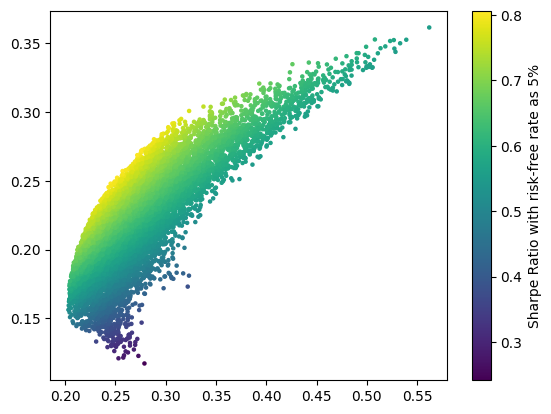

In [562]:
plot.scatter(pstd, pm, c = psharpe, s=5)
plot.colorbar(label="Sharpe Ratio with risk-free rate as 5%")

Determine Point with Minimal Risk & Point with Minimal Sharpe Ratio & Efficiency Frontier

In [563]:
def Min_Risk(weights):
    return Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[1]

def Max_Sharpe(weights):
    return -Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[2]

def M_Return(weights):
     return Stat_Portfolio(weights, R_mu, R_std, R_corr, TRSRY)[0]

In [564]:
Cons = ({'type': 'eq','fun': lambda w: np.sum(w) - 1})
Bnds = (((0,1),) * len(STK_df.columns))
Init = [1/len(STK_df.columns)] * len(STK_df.columns)
print(Bnds)
print(Init)

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
[0.2, 0.2, 0.2, 0.2, 0.2]


In [565]:
Min_Risk_W = spyop.minimize(Min_Risk,Init, method = 'SLSQP', bounds = Bnds, constraints = Cons )['x']
Min_Risk_W

array([2.90921971e-18, 4.03388539e-02, 2.88045489e-01, 9.17036033e-02,
       5.79912054e-01])

In [566]:
Min_Risk_result = Stat_Portfolio(Min_Risk_W, R_mu, R_std, R_corr, TRSRY)
Min_Risk_pm = Min_Risk_result[0]
Min_Risk_pstd = Min_Risk_result[1]

In [567]:
Max_Sharpe_W = spyop.minimize(Max_Sharpe,Init, method = 'SLSQP', bounds = Bnds, constraints = Cons )['x']
Max_Sharpe_W

array([1.24682991e-01, 5.92662788e-01, 1.23599048e-17, 0.00000000e+00,
       2.82654221e-01])

In [568]:
Max_Sharpe_result = Stat_Portfolio(Max_Sharpe_W, R_mu, R_std, R_corr, TRSRY)
Max_Sharpe_pm = Max_Sharpe_result[0]
Max_Sharpe_pstd = Max_Sharpe_result[1]
Max_Sharpe_psharpe = Max_Sharpe_result[2]

Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

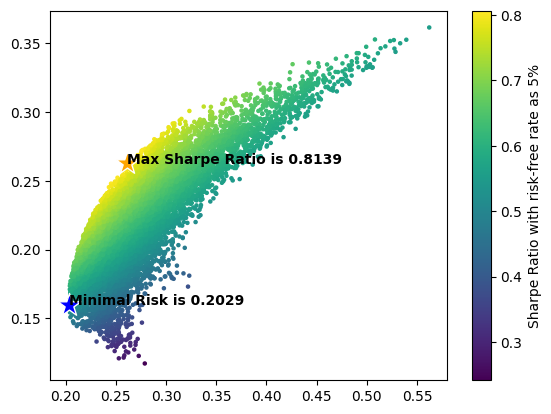

In [569]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")

Efficient Frontier & Capital Line

In [570]:
target_m= np.linspace(Min_Risk_pm,np.max(pm),50)

EF_m = []
EF_std = []
for target in target_m:
    Cons_EF = ({'type': 'eq','fun': lambda w: np.sum(w) - 1},
                {'type': 'eq','fun': lambda w: M_Return(w) - target})
    w = spyop.minimize(Max_Sharpe,Init, method = 'SLSQP', bounds = Bnds, constraints = Cons_EF )['x']
    r = Stat_Portfolio(w, R_mu, R_std, R_corr, TRSRY)
    EF_m.append(r[0])
    EF_std.append(r[1])


Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

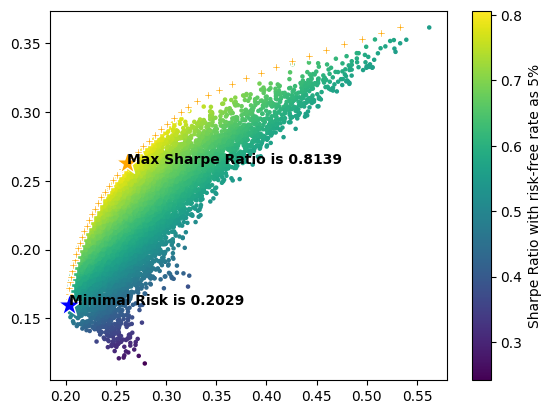

In [571]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

ax.scatter(EF_std, EF_m, marker = 'P', c='orange', edgecolors='w')
ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")



Text(0.26138452018512626, 0.2627463731862672, 'Max Sharpe Ratio is 0.8139')

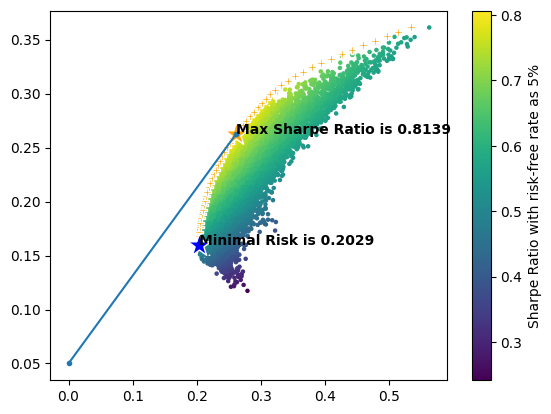

In [572]:
fig, ax = plot.subplots()
grph = ax.scatter(pstd, pm, c = psharpe, s=5)
plot.colorbar(grph, label="Sharpe Ratio with risk-free rate as 5%")

x1, y1 = [0, Max_Sharpe_pstd], [TRSRY, Max_Sharpe_pm]
ax.plot(x1, y1, marker='.')

ax.scatter(EF_std, EF_m, marker = 'P', c='orange', edgecolors='w')
ax.scatter(Min_Risk_pstd, Min_Risk_pm,marker = '*', c='b',edgecolor = 'white', s = 300)
ax.scatter(Max_Sharpe_pstd, Max_Sharpe_pm,marker = '*', c='orange',edgecolor = 'white', s = 300)
ax.annotate(f'Minimal Risk is {Min_Risk_pstd.round(4)}', (Min_Risk_pstd, Min_Risk_pm), weight = "bold")
ax.annotate(f'Max Sharpe Ratio is {Max_Sharpe_psharpe.round(4)}', (Max_Sharpe_pstd, Max_Sharpe_pm), weight = "bold")



Verify the efficiency of weights with maximum sharpe ratio
- See the actual return rate for 6 month
- Check the average return & risk

In [636]:
STK_df_test = STK_df_raw[(STK_df_raw.index >= '2023-06-01') & (STK_df_raw.index <= '2024-06-20')]
tst_pm = STK_df_test.mean()
tst_pstd = STK_df_test.std()
tst_corr = STK_df_test.corr()

#With Equal Weights
Eql_w = Stat_Portfolio(Init, tst_pm, tst_pstd, tst_corr, TRSRY)
Opt_w = Stat_Portfolio(Max_Sharpe_W, tst_pm, tst_pstd, tst_corr, TRSRY)
print(list(zip(['eql_return', 'eql_risk', 'eql_sharpe ratio'], list(Eql_w))))
print(list(zip(['opt_return', 'opt_risk', 'opt_sharpe ratio'], list(Opt_w))))
print(f'Reletive Increase in Sharpe Ratio:  {(Opt_w[2] - Eql_w[2])/Eql_w[2]}')


[('eql_return', 0.22167100938989304), ('eql_risk', 0.010970340408572287), ('eql_sharpe ratio', 15.648649266685318)]
[('opt_return', 0.2627463731862672), ('opt_risk', 0.010938531374049144), ('opt_sharpe ratio', 19.44926296879234)]
Reletive Increase in Sharpe Ratio:  0.24287167776187651
